In [ ]:
####### pip installs

# 1. Install system dependencies
!apt-get update
!apt-get install -y swig cmake ffmpeg xvfb python3-opengl

# 2. Install Python packages
!pip install gymnasium[box2d] stable-baselines3[extra] pyvirtualdisplay

Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,860 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,572 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [6,205 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,633 kB]
Get:14 http:/

In [ ]:
######## code for virtual display and google drive mount

from pyvirtualdisplay import Display
from google.colab import drive
import os

# Start virtual display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

# Mount Drive
drive.mount('/content/drive')

# Verify the path exists
save_path = "/content/drive/MyDrive/RL_Hardcore_Project/"
if os.path.exists(save_path):
    print(f"✅ Drive connected. Project folder found at: {save_path}")
else:
    print("❌ Path not found. Check your Drive folder name.")

Mounted at /content/drive
✅ Drive connected. Project folder found at: /content/drive/MyDrive/RL_Hardcore_Project/


In [ ]:
######## This code loads previously saved SAC model, env stats and replay buffer
######## from google drive and resumes training from where it was previously left off.
######## Allows manual stop to save progress and saves best model so far for furture investigation or restart

import gymnasium as gym
import numpy as np
import os
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback, CallbackList
from stable_baselines3.common.noise import NormalActionNoise

# --- 1. CONFIGURATION ---
TARGET_STEPS = 1000000
SAVE_FREQ = 50000
DRIVE_PATH = "/content/drive/MyDrive/RL_Hardcore_Project/"

# Update these to your latest 750k files
LOAD_MODEL = os.path.join(DRIVE_PATH, "sac_hardcore_resume2_750000_steps.zip")
LOAD_STATS = os.path.join(DRIVE_PATH, "sac_hardcore_resume2_750000_steps_vecnormalize.pkl")
LOAD_BUFFER = os.path.join(DRIVE_PATH, "sac_hardcore_resume2_750000_steps_replay_buffer.pkl")

# --- 2. ENVIRONMENT SETUP ---
def make_env():
    return gym.make("BipedalWalkerHardcore-v3")

env = DummyVecEnv([make_env])

# Load Normalization
if os.path.exists(LOAD_STATS):
    env = VecNormalize.load(LOAD_STATS, env)
    print("✅ VecNormalize stats loaded.")

# --- 3. EVALUATION ENV (For Best Model Tracking) ---
# We need a separate env so evaluation doesn't mess with training stats
eval_env = DummyVecEnv([make_env])
if os.path.exists(LOAD_STATS):
    eval_env = VecNormalize.load(LOAD_STATS, eval_env)
    eval_env.training = False # Turn off updates for evaluation
    eval_env.norm_reward = False

# --- 4. THE "PUNCH": ACTION NOISE ---
n_actions = env.action_space.shape[-1]
# Sigma 0.1 provides enough "wobble" to force the agent to learn recovery
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# --- 5. LOAD THE AGENT ---
LR = 5e-5
GRAD_CLIP = 0.5

model = SAC.load(
    LOAD_MODEL,
    env=env,
    custom_objects={
        "learning_rate": LR,
        "max_grad_norm": GRAD_CLIP,
        "action_noise": action_noise
    }
)

if os.path.exists(LOAD_BUFFER):
    model.load_replay_buffer(LOAD_BUFFER)
    print("🧠 Replay Buffer loaded.")

# --- 6. CALLBACKS ---
# A. Periodic Checkpoint
checkpoint_callback = CheckpointCallback(
    save_freq=SAVE_FREQ,
    save_path=DRIVE_PATH,
    name_prefix="sac_hardcore_turbo",
    save_replay_buffer=True,
    save_vecnormalize=True
)

# B. Best Model Saver (Checks every 10,000 steps)
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=DRIVE_PATH,
    log_path=DRIVE_PATH,
    eval_freq=10000,
    deterministic=True,
    render=False
)

# Combine them
callback_list = CallbackList([checkpoint_callback, eval_callback])

# --- 7. TRAIN ---
print("🚀 Launching Turbo-Phase with Best Model tracking...")
try:
    model.learn(
        total_timesteps=TARGET_STEPS,
        callback=callback_list,
        reset_num_timesteps=False,
        progress_bar=True
    )
except KeyboardInterrupt:
    print("\n🛑 Manual Interrupt. Saving current state...")
    model.save(os.path.join(DRIVE_PATH, "sac_manual_emergency_stop.zip"))
    env.save(os.path.join(DRIVE_PATH, "sac_manual_emergency_stats.pkl"))

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: Dep

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: 
datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects 
to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

🚀 Launching Turbo-Phase with Best Model tracking...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 424      |
|    ep_rew_mean     | -76.8    |
| time/              |          |
|    episodes        | 1076     |
|    fps             | 11       |
|    time_elapsed    | 17       |
|    total_timesteps | 750196   |
| train/             |          |
|    actor_loss      | 0.463    |
|    critic_loss     | 143      |
|    ent_coef        | 0.00109  |
|    ent_coef_loss   | 13.9     |
|    learning_rate   | 5e-05    |
|    n_updates       | 750091   |
---------------------------------


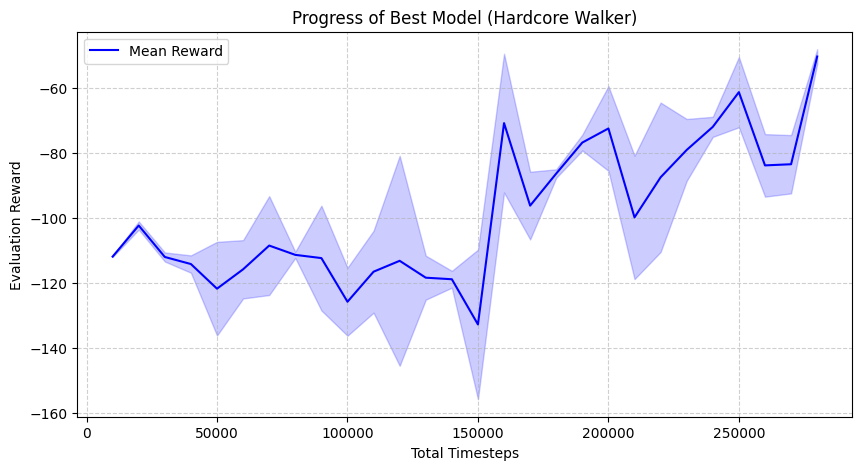

In [ ]:
##### code for plotting reward results
import matplotlib.pyplot as plt
import numpy as np
import os

DRIVE_PATH = "/content/drive/MyDrive/RL_Hardcore_Project/"
NPZ_FILE = os.path.join(DRIVE_PATH, "evaluations.npz")

if os.path.exists(NPZ_FILE):
    data = np.load(NPZ_FILE)

    # Extract data
    timesteps = data['timesteps']
    results = data['results'] # Usually shape (num_evals, num_episodes)

    # Calculate mean and standard deviation for a better look
    mean_rewards = np.mean(results, axis=1)
    std_rewards = np.std(results, axis=1)

    plt.figure(figsize=(10, 5))
    plt.plot(timesteps, mean_rewards, label='Mean Reward', color='blue')
    plt.fill_between(timesteps, mean_rewards - std_rewards, mean_rewards + std_rewards, color='blue', alpha=0.2)

    plt.title("Progress of Best Model (Hardcore Walker)")
    plt.xlabel("Total Timesteps")
    plt.ylabel("Evaluation Reward")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()
else:
    print(f"❌ Could not find {NPZ_FILE}. Is training still running its first 10k steps?")

In [ ]:
###### code for loading speicific runs or best runs in order to make a video to study walker performance

import gymnasium as gym
import numpy as np
import os
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

DRIVE_PATH = "/content/drive/MyDrive/RL_Hardcore_Project/"

# --- 1. CONFIGURATION ---
#BEST_MODEL_PATH = os.path.join(DRIVE_PATH, "best_model.zip")
BEST_MODEL_PATH = os.path.join(DRIVE_PATH, "sac_hardcore_200000_steps.zip")
# Since EvalCallback doesn't save a unique .pkl, we use the most recent
# stats file or the manual stop stats.
STATS_PATH = os.path.join(DRIVE_PATH, "sac_hardcore_vecnormalize_200000_steps.pkl")
NPZ_PATH = os.path.join(DRIVE_PATH, "evaluations.npz")

# --- 2. CHECK THE "HIGH SCORE" ---
if os.path.exists(NPZ_PATH):
    data = np.load(NPZ_PATH)
    # data['results'] contains the rewards for each evaluation
    mean_rewards = np.mean(data['results'], axis=1)
    best_idx = np.argmax(mean_rewards)
    print(f"🏆 Best Evaluation Reward found: {mean_rewards[best_idx]:.2f} at eval index {best_idx}")

# --- 3. ENVIRONMENT SETUP ---
def make_env():
    return gym.make("BipedalWalkerHardcore-v3", render_mode="rgb_array")

eval_env = DummyVecEnv([make_env])

if os.path.exists(STATS_PATH):
    eval_env = VecNormalize.load(STATS_PATH, eval_env)
    eval_env.training = False
    eval_env.norm_reward = False
    print("✅ Stats loaded.")

# --- 4. LOAD & SIMULATE ---
if os.path.exists(BEST_MODEL_PATH):
    model = SAC.load(BEST_MODEL_PATH, env=eval_env)
    print("🤖 Best Model loaded.")

    obs = eval_env.reset()
    frames = []
    for _ in range(1500): # Record 1500 frames
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = eval_env.step(action)
        frames.append(eval_env.render())
        if done: break

    # --- 5. ANIMATE ---
    plt.figure(figsize=(8, 5))
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=30)
    display(HTML(anim.to_jshtml()))
else:
    print("❌ Best model not found yet. Keep training!")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
######## This code loads SAC env stats and creates a new run of learning with TD3
######## loading is from google drive
######## Allows manual stop to save progress and saves best model so far for furture investigation or restart


import gymnasium as gym
import numpy as np
import os
from stable_baselines3 import TD3
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback, CallbackList
from stable_baselines3.common.noise import NormalActionNoise

# --- 1. CONFIGURATION ---
TARGET_STEPS = 1000000
SAVE_FREQ = 50000
DRIVE_PATH = "/content/drive/MyDrive/RL_Hardcore_Project/"

# Using your best stats to ensure TD3 starts with the correct "Vision"
LOAD_STATS = os.path.join(DRIVE_PATH, "sac_hardcore_resume2_750000_steps_vecnormalize.pkl")

# --- 2. ENVIRONMENT SETUP ---
def make_env():
    return gym.make("BipedalWalkerHardcore-v3")

env = DummyVecEnv([make_env])

if os.path.exists(LOAD_STATS):
    env = VecNormalize.load(LOAD_STATS, env)
    print("✅ VecNormalize stats loaded (Transferring Vision to TD3).")

eval_env = DummyVecEnv([make_env])
if os.path.exists(LOAD_STATS):
    eval_env = VecNormalize.load(LOAD_STATS, eval_env)
    eval_env.training = False
    eval_env.norm_reward = False

# --- 3. TD3 SPECIFIC NOISE (Crucial for TD3) ---
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# --- 4. INITIALIZE TD3 ---
# We use the same 512x512 architecture you preferred
policy_kwargs = dict(net_arch=[512, 512])

# TD3 is less sensitive to high LR, but we'll stay conservative
model = TD3(
    "MlpPolicy",
    env,
    learning_rate=1e-4,
    buffer_size=1000000,
    learning_starts=10000, # Give it a moment to fill buffer with TD3 logic
    action_noise=action_noise,
    policy_kwargs=policy_kwargs,
    tensorboard_log=os.path.join(DRIVE_PATH, "logs"),
    verbose=1,
    device="auto"
)

# --- 5. CALLBACKS (Best Model + Checkpoints) ---
checkpoint_callback = CheckpointCallback(
    save_freq=SAVE_FREQ,
    save_path=DRIVE_PATH,
    name_prefix="td3_hardcore_turbo",
    save_replay_buffer=True,
    save_vecnormalize=True
)

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=DRIVE_PATH,
    log_path=DRIVE_PATH,
    eval_freq=10000,
    deterministic=True,
    render=False
)

callback_list = CallbackList([checkpoint_callback, eval_callback])

# --- 6. TRAIN ---
print("🚀 Launching TD3 Phase. Watch for 'best_model.zip' in Drive.")
try:
    model.learn(
        total_timesteps=TARGET_STEPS,
        callback=callback_list,
        progress_bar=True
    )
except KeyboardInterrupt:
    print("\n🛑 Saving TD3 state...")
    model.save(os.path.join(DRIVE_PATH, "td3_manual_stop.zip"))
    env.save(os.path.join(DRIVE_PATH, "td3_manual_stop_stats.pkl"))

print("🏁 TD3 Training Session Complete.")

  27% ━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270,949/1,000,000  [ 4:00:13 < 10:43:16 , 19 it/s ]

In [ ]:
###### code for loading speicific runs or best runs  of TD3 in order to make a video to study walker performance
import gymnasium as gym
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from stable_baselines3 import TD3
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

# --- 1. CONFIGURATION ---
DRIVE_PATH = "/content/drive/MyDrive/RL_Hardcore_Project/"

# The specific 250k TD3 Checkpoint
MODEL_PATH = os.path.join(DRIVE_PATH, "td3_hardcore_turbo_200000_steps.zip")
# Use the stats you loaded for the TD3 run
STATS_PATH = os.path.join(DRIVE_PATH, "sac_hardcore_resume2_750000_steps_vecnormalize.pkl")

# --- 2. ENVIRONMENT SETUP ---
def make_env():
    # render_mode must be rgb_array for the video
    return gym.make("BipedalWalkerHardcore-v3", render_mode="rgb_array")

env = DummyVecEnv([make_env])

# Load the vision (normalization stats)
if os.path.exists(STATS_PATH):
    env = VecNormalize.load(STATS_PATH, env)
    env.training = False
    env.norm_reward = False
    print("✅ Normalization stats loaded.")

# --- 3. LOAD THE TD3 AGENT ---
if os.path.exists(MODEL_PATH):
    model = TD3.load(MODEL_PATH, env=env)
    print(f"🤖 TD3 250k Model loaded successfully.")

    # --- 4. RUN SIMULATION ---
    obs = env.reset()
    frames = []
    total_reward = 0

    for _ in range(1000): # Record 1000 frames (about 20-30 seconds)
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        frames.append(env.render())
        total_reward += reward[0]
        if done: break

    print(f"🎬 Video generated. Episode Reward: {total_reward:.2f}")

    # --- 5. RENDER VIDEO ---
    plt.figure(figsize=(8, 5))
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=30)
    display(HTML(anim.to_jshtml()))
else:
    print(f"❌ Error: Model file not found at {MODEL_PATH}")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
###### code for install of ffmpeg to get walker performace video to mp4.
!apt-get install -y ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


In [ ]:
###### code for rendering walker performance after SAC training directly into mp4 instead displaing in colab like the above
import gymnasium as gym
import numpy as np
import os
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import matplotlib.pyplot as plt
from matplotlib import animation

# --- 1. CONFIGURATION ---
DRIVE_PATH = "/content/drive/MyDrive/RL_Hardcore_Project/"
MODEL_PATH = os.path.join(DRIVE_PATH, "sac_hardcore_200000_steps.zip")
STATS_PATH = os.path.join(DRIVE_PATH, "sac_hardcore_vecnormalize_200000_steps.pkl")
VIDEO_SAVE_PATH = os.path.join(DRIVE_PATH, "walker_performance_200k.mp4")

# --- 2. ENVIRONMENT & MODEL SETUP ---
def make_env():
    return gym.make("BipedalWalkerHardcore-v3", render_mode="rgb_array")

eval_env = DummyVecEnv([make_env])
if os.path.exists(STATS_PATH):
    eval_env = VecNormalize.load(STATS_PATH, eval_env)
    eval_env.training = False
    eval_env.norm_reward = False

if os.path.exists(MODEL_PATH):
    model = SAC.load(MODEL_PATH, env=eval_env)

    # --- 3. GENERATE FRAMES ---
    obs = eval_env.reset()
    frames = []
    print("🎬 Simulating episodes...")
    for _ in range(1500):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = eval_env.step(action)
        frames.append(eval_env.render())
        if done: break

    # --- 4. SAVE AS MP4 ---
    print(f"💾 Saving video to: {VIDEO_SAVE_PATH}")
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    ax.axis('off')

    im = ax.imshow(frames[0])

    def update(i):
        im.set_array(frames[i])
        return [im]

    # bit_rate helps with video quality; 30fps matches your previous interval
    ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=30)

    writer = animation.FFMpegWriter(fps=30, metadata=dict(artist='Me'), bitrate=1800)
    ani.save(VIDEO_SAVE_PATH, writer=writer)

    plt.close() # Prevents extra empty plot from showing in Colab
    print("✅ Done! You can find the file in your Google Drive.")
else:
    print("❌ Model not found.")

🎬 Simulating episodes...
💾 Saving video to: /content/drive/MyDrive/RL_Hardcore_Project/walker_performance_200k.mp4


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


✅ Done! You can find the file in your Google Drive.


In [ ]:
###### code for rendering walker performance after TD3 training directly into mp4 instead displaing in colab like the above

import gymnasium as gym
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import animation
from stable_baselines3 import TD3
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

# --- 1. CONFIGURATION ---
DRIVE_PATH = "/content/drive/MyDrive/RL_Hardcore_Project/"
MODEL_PATH = os.path.join(DRIVE_PATH, "td3_hardcore_turbo_200000_steps.zip")
STATS_PATH = os.path.join(DRIVE_PATH, "sac_hardcore_resume2_750000_steps_vecnormalize.pkl")
VIDEO_SAVE_PATH = os.path.join(DRIVE_PATH, "td3_performance_200k.mp4")

# --- 2. ENVIRONMENT SETUP ---
def make_env():
    return gym.make("BipedalWalkerHardcore-v3", render_mode="rgb_array")

env = DummyVecEnv([make_env])

if os.path.exists(STATS_PATH):
    env = VecNormalize.load(STATS_PATH, env)
    env.training = False
    env.norm_reward = False
    print("✅ Normalization stats loaded.")

# --- 3. LOAD THE TD3 AGENT ---
if os.path.exists(MODEL_PATH):
    model = TD3.load(MODEL_PATH, env=env)
    print(f"🤖 TD3 Model loaded from {MODEL_PATH}")

    # --- 4. RUN SIMULATION ---
    obs = env.reset()
    frames = []
    total_reward = 0
    print("🎬 Simulating and capturing frames...")

    for _ in range(1200): # Capturing slightly more frames for a longer look
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        frames.append(env.render())
        total_reward += reward[0]
        if done: break

    print(f"✅ Simulation complete. Episode Reward: {total_reward:.2f}")

    # --- 5. SAVE AS MP4 ---
    print(f"💾 Saving video to Drive: {VIDEO_SAVE_PATH}")
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.axis('off')
    im = ax.imshow(frames[0])

    def update(i):
        im.set_array(frames[i])
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=30)

    # Save using FFMpegWriter
    writer = animation.FFMpegWriter(fps=30, metadata=dict(artist='Gemini_AI'), bitrate=1800)
    ani.save(VIDEO_SAVE_PATH, writer=writer)

    plt.close() # Clean up memory
    print("🏁 Video file successfully saved to Drive.")
else:
    print(f"❌ Error: Model file not found.")

🤖 TD3 Model loaded from /content/drive/MyDrive/RL_Hardcore_Project/td3_hardcore_turbo_200000_steps.zip
🎬 Simulating and capturing frames...
✅ Simulation complete. Episode Reward: -46.86
💾 Saving video to Drive: /content/drive/MyDrive/RL_Hardcore_Project/td3_performance_200k.mp4


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


🏁 Video file successfully saved to Drive.
